# **Tutorial 5 SpatialEx+ Enables Spatial Multi-omics through Omics Diagonal Integration (transcriptomics-metabolomics)**

The mouse brain MSA data were preprocessed in another study, citation is here: 📄
<a href="https://doi.org/10.1101/2024.12.05.626986">NicheTrans</a>.

And you can find the corresponding data here: 🔗 
[Zenodo](https://zenodo.org/records/15706278).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpatialEx as se

device = 'cuda:7'

## 1. Prepare the dataset

### Arange your dataset folder as below:
```
datasets/
│
├── V11L12-109_C1/                                # The 1st slice
│   ├── metabolite_V11L12-109_C1.h5ad            # Train
│   ├── rna_V11L12-109_C1.h5ad                   # Evaluation
│   ├── 220506_MSi_V11L12-109_C1.jpg       
│   ├── V11L12-109_C1_cell_coor_out_spot.csv     # We get this manually
│   ├── C1_out_uni_res580.npy
│
├── V11L12-109_B1/                                # The 2nd slice                   
│   ├── metabolite_V11L12-109_B1.h5ad            # Evaluation
│   ├── rna_V11L12-109_B1.h5ad                   # Train   
│   └── 220506_MSi_V11L12-109_B1.jpg
│   ├── V11L12-109_B1_cell_coor_out_spot.csv
│   ├── B1_out_uni_res580.npy
```

In [ ]:
resolution = 580
image_encoder = 'uni'
save_root = '/home/wcy/code/datasets/MSA/'
sample_name1 = 'V11L12-109_C1'
sample_name2 = 'V11L12-109_B1'

In [ ]:
file_path1 = save_root + sample_name1 + '/rna_V11L12-109_C1.h5ad'
img_path1 = save_root + sample_name1 + '/220506_MSi_V11L12-109_C1.jpg'

C1_rna = sc.read_h5ad(file_path1)
C1_rna.var_names_make_unique()
sc.pp.filter_genes(C1_rna, min_cells=1)
C1_rna.var["mt"] = C1_rna.var_names.str.startswith("mt-")
C1_rna = C1_rna[:, ~C1_rna.var["mt"]]
sc.pp.log1p(C1_rna)
C1_rna = se.pp.Preprocess_adata(C1_rna, cell_mRNA_cutoff=0, scale=True)
adj = se.pp.Build_graph(C1_rna.obsm['spatial'], graph_type='knn').todense().A
moransI = se.utils.Compute_MoransI(C1_rna, adj)
mz_selected = C1_rna.var_names[np.argsort(moransI)[-1000:]]
C1_rna = C1_rna[:, mz_selected]    

img, _ = se.pp.Read_HE_image(img_path1, suffix='.jpg')
he_patches, C1_rna = se.pp.Tiling_HE_patches(resolution, C1_rna, img, key='spatial')
C1_rna = se.pp.Extract_HE_patches_representaion(he_patches, 'he', C1_rna, image_encoder=image_encoder, device=device)

In [2]:
file_path2 = save_root + sample_name2 + '/metabolite_V11L12-109_B1.h5ad'
img_path2 = save_root + sample_name2 + '/220506_MSi_V11L12-109_B1.jpg'

B1_metabolite = sc.read_h5ad(file_path2)
B1_metabolite.var_names = B1_metabolite.var['metabolism'].values
B1_metabolite.var_names_make_unique()
sc.pp.filter_genes(B1_metabolite, min_cells=1)
B1_metabolite = se.pp.Preprocess_adata(B1_metabolite, cell_mRNA_cutoff=0, scale=True)
adj = se.pp.Build_graph(B1_metabolite.obsm['spatial'], graph_type='knn').todense().A 
moransI = se.utils.Compute_MoransI(B1_metabolite, adj)
mz_selected = B1_metabolite.var_names[np.argsort(moransI)[-50:]]
B1_metabolite = B1_metabolite[:, mz_selected]    

img, _ = se.pp.Read_HE_image(img_path2, suffix='.jpg')
he_patches, B1_metabolite = se.pp.Tiling_HE_patches(resolution, B1_metabolite, img, key='spatial')
B1_metabolite = se.pp.Extract_HE_patches_representaion(he_patches, 'he', B1_metabolite, image_encoder=image_encoder,device=device)

======================== Tiling HE patches for each single cells ===========================
patch radius is  290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2907/2907 [00:00<00:00, 5123.75it/s]


====================== Extracting HE representations for each cell =========================
The image encoder is uni


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:28<00:00,  1.61it/s]


======================== Tiling HE patches for each single cells ===========================
patch radius is  290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3098/3098 [00:00<00:00, 4920.70it/s]


====================== Extracting HE representations for each cell =========================
The image encoder is uni


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


## 2. Train SpatialExP

### 2.1 Within the squencing area

In [3]:
num_neighbors = 2

graph1 = se.pp.Build_hypergraph(C1_rna.obsm['spatial'], num_neighbors=num_neighbors, normalize=True)
graph2 = se.pp.Build_hypergraph(B1_metabolite.obsm['spatial'], num_neighbors=num_neighbors, normalize=True)

spatialexp =se.SpatialExP(C1_rna, B1_metabolite, graph1, graph2, platform='Visium', device=device, epochs=600)
spatialexp.train()
C1_metabolite_prime, B1_rna_prime = spatialexp.auto_inference()



=================================== Start training =========================================


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:26<00:00, 22.33it/s]


### 2.2 Outside the squencing area

In [4]:
C1_spatial_out = pd.read_csv(save_root + sample_name1 + '/V11L12-109_C1_cell_coor_out_spot.csv', index_col=0)
B1_spatial_out = pd.read_csv(save_root + sample_name2 + '/V11L12-109_B1_cell_coor_out_spot.csv', index_col=0)
C1_he_out = np.load(save_root + sample_name1 + '/C1_out_uni_res580.npy')
B1_he_out = np.load(save_root + sample_name2 + '/B1_out_uni_res580.npy')

graph1 = se.pp.Build_hypergraph(C1_spatial_out.values, num_neighbors=num_neighbors, normalize=True)
graph2 = se.pp.Build_hypergraph(B1_spatial_out.values, num_neighbors=num_neighbors, normalize=True)

C1_rna_out = spatialexp.inference_indirect(C1_he_out, graph1, panel='panelA')
B1_rna_out = spatialexp.inference_indirect(B1_he_out, graph2, panel='panelA')
C1_metabolite_out = spatialexp.inference_indirect(C1_he_out, graph1, panel='panelB')
B1_metabolite_out = spatialexp.inference_indirect(B1_he_out, graph2, panel='panelB')

## 3. Evaluation

### 3.1 Quantative metric

#### 3.1.1 Evaluation of predicted transcriptomics on Slice C1

In [5]:
C1_metabolite = sc.read_h5ad(save_root + sample_name1 + '/metabolite_V11L12-109_C1.h5ad')
C1_metabolite.var_names = C1_metabolite.var['metabolism'].values
C1_metabolite.var_names_make_unique()
C1_metabolite = C1_metabolite[:, B1_metabolite.var_names]
C1_metabolite = C1_metabolite[C1_rna.obs_names]
C1_metabolite = se.pp.Preprocess_adata(C1_metabolite, cell_mRNA_cutoff=0, scale=True)

pcc, pcc_reduce = se.utils.Compute_metrics(C1_metabolite.X.copy(), C1_metabolite_prime.copy(), metric='pcc', reduce='mean')
cmd, cmd_reduce = se.utils.Compute_metrics(C1_metabolite.X.copy(), C1_metabolite_prime.copy(), metric='cmd', reduce='mean')
print('Evaluation of predicted metabolites on Slice 1, PCC:', pcc_reduce, ', CMD:', cmd_reduce)

Evaluation of predicted transcriptomics on Slice 1, PCC: 0.5009825 , CMD: 0.04929069147980192


#### 3.1.2 Evaluation of predicted metabolites on Slice B1

In [6]:
B1_rna = sc.read_h5ad(save_root + sample_name2 + '/rna_V11L12-109_B1.h5ad')
B1_rna.var_names_make_unique()
B1_rna = B1_rna[:, C1_rna.var_names]
B1_rna = B1_rna[B1_metabolite.obs_names]
sc.pp.log1p(B1_rna)
B1_rna = se.pp.Preprocess_adata(B1_rna, cell_mRNA_cutoff=0, scale=True)

pcc, pcc_reduce = se.utils.Compute_metrics(B1_rna.X.copy(), B1_rna_prime.copy(), metric='pcc', reduce='mean')
cmd, cmd_reduce = se.utils.Compute_metrics(B1_rna.X.copy(), B1_rna_prime.copy(), metric='cmd', reduce='mean')
print('Evaluation of predicted transcriptomics on Slice 2, PCC:', pcc_reduce, ', CMD:', cmd_reduce)

Evaluation of predicted metabolites on Slice 2, PCC: 0.37037066 , CMD: 0.04292133410095511


### 3.2 Visualization

In [7]:
C1_inner_x, C1_inner_y = C1_rna.obsm['spatial'][:, 0], C1_rna.obsm['spatial'][:, 1]
B1_inner_x, B1_inner_y = B1_metabolite.obsm['spatial'][:, 0], B1_metabolite.obsm['spatial'][:, 1]
C1_outer_x, C1_outer_y = C1_spatial_out['image_col'].values, C1_spatial_out['image_row'].values
B1_outer_x, B1_outer_y = B1_spatial_out['image_col'].values, B1_spatial_out['image_row'].values

#### 3.2.1 Predicted transcriptomics on Slice B1

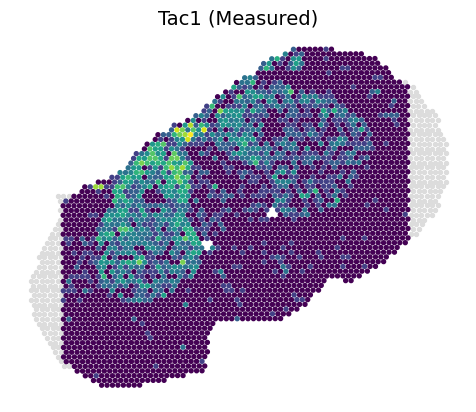

In [8]:
feat_name = 'Tac1'
feat_idx = np.where(C1_rna.var_names == feat_name)[0]

value = B1_rna[:, feat_name].X
plt.scatter(B1_inner_x, B1_inner_y, c=value, s=8, zorder=2)
plt.scatter(B1_outer_x, B1_outer_y, c='#DCDCDC', s=8, zorder=1)

ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.title(feat_name+' (Measured)', fontsize=14)
plt.show()

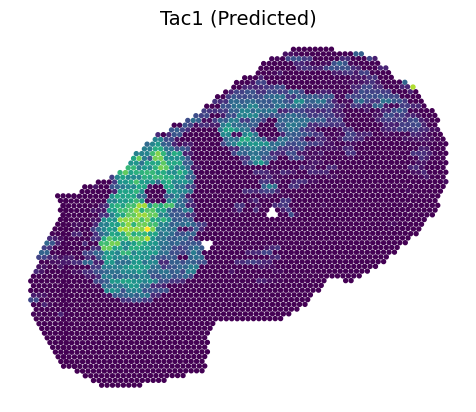

In [9]:
feat_name = 'Tac1'
feat_idx = np.where(C1_rna.var_names == feat_name)[0]

value = B1_rna_prime[:, feat_idx]
vmin, vmax = value.min()+0.22, value.max()
plt.scatter(B1_inner_x, B1_inner_y, c=value, s=8, vmin=vmin, vmax=vmax, zorder=2)
value = B1_rna_out[:, feat_idx]
plt.scatter(B1_outer_x, B1_outer_y, c=value, s=8, vmin=vmin, vmax=vmax, zorder=1)

ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.title(feat_name+' (Predicted)', fontsize=14)
plt.show()

#### 3.2.2 Predicted metabolites on Slice C1

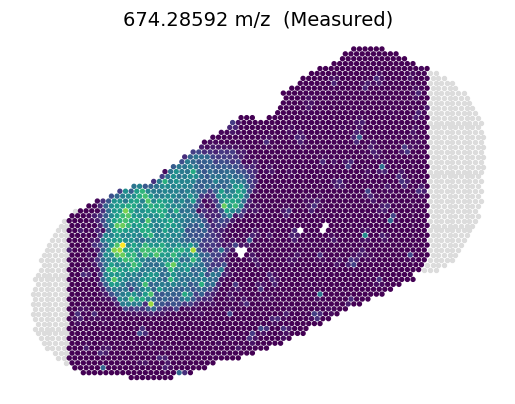

In [10]:
feat_name = '674.28592'
feat_idx = np.where(B1_metabolite.var_names == feat_name)[0]

value = C1_metabolite[:, feat_name].X
vmin, vmax =value.min(), value.max()
plt.scatter(C1_inner_x, C1_inner_y, c=value, s=8, vmin=vmin, vmax=vmax, zorder=2)
plt.scatter(C1_outer_x, C1_outer_y, c='#DCDCDC', s=8, zorder=1)

ax = plt.gca().set_aspect(1)
plt.axis('off')
plt.title(feat_name+' m/z  (Measured)', fontsize=14)
plt.show()

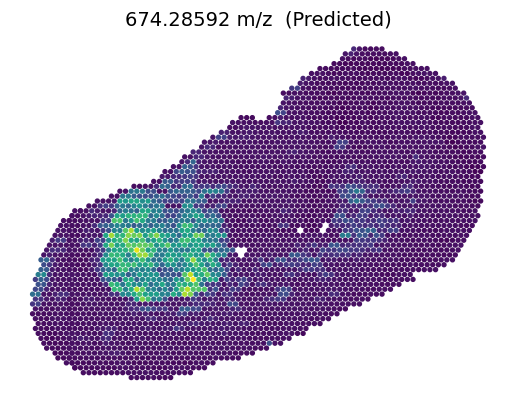

In [11]:
feat_name = '674.28592'
feat_idx = np.where(B1_metabolite.var_names == feat_name)[0]

value = C1_metabolite_prime[:, feat_idx]
vmin, vmax =value.min(), value.max()
plt.scatter(C1_inner_x, C1_inner_y, c=value, s=8, vmin=vmin, vmax=vmax, zorder=2)
value = C1_metabolite_out[:, feat_idx]
plt.scatter(C1_outer_x, C1_outer_y, c=value, s=8, vmin=vmin, vmax=vmax, zorder=1)

ax = plt.gca().set_aspect(1)
plt.axis('off')
plt.title(feat_name+' m/z  (Predicted)', fontsize=14)
plt.show()